# Evaluate model performance

In [2]:
# Load price data
import pandas as pd
prices = pd.read_csv('data/eurusd_minute.csv')['BidClose'].values

In [3]:
from src.dataset import EncodedForexData
import numpy as np
from tqdm.notebook import tqdm

from src.encoders import SimpleRasterizeEncoder, GasfEncoder
simple_dataset = EncodedForexData(prices, 64, encoder=SimpleRasterizeEncoder(), relative=False)
# rel_simple_dataset = EncodedForexData(prices, 64, encoder=SimpleRasterizeEncoder(), relative=True)
# gasf_dataset = EncodedForexData(prices, 64, encoder=GasfEncoder(), relative=False)

standardize = lambda x: (x-x.mean())/x.std()

simple_encoder = SimpleRasterizeEncoder()
gasf_encoder = GasfEncoder()

In [4]:
samples = [simple_encoder.decode(x) for x in tqdm(simple_dataset)]
simple_data = np.concatenate([standardize(np.diff(x)) for x in tqdm(samples)])
# rel_samples = [simple_encoder.decode(x) for x in tqdm(rel_simple_dataset)]
# rel_data = np.concatenate([standardize(x) for x in tqdm(rel_samples)])
# gasf_samples = [gasf_encoder.decode(x) for x in tqdm(gasf_dataset)]
# gasf_data = np.concatenate([standardize(np.diff(x)) for x in tqdm(gasf_samples)])
# print(simple_data.shape, rel_data.shape, gasf_data.shape)

  0%|          | 0/80690 [00:00<?, ?it/s]

  0%|          | 0/80690 [00:00<?, ?it/s]

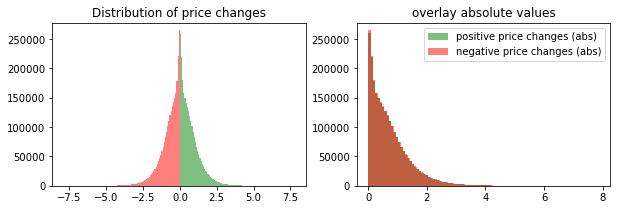

In [12]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,3))
ax1.hist(simple_data[simple_data>0], bins=100, color='green', alpha=0.5)
ax1.hist(simple_data[simple_data<0], bins=100, color='red', alpha=0.5)
ax1.set_title('Distribution of price changes')
ax2.hist(simple_data[simple_data>0], bins=100, label="positive price changes (abs)", alpha=0.5, color='green')
ax2.hist(-simple_data[simple_data<0], bins=100, label="negative price changes (abs)", alpha=0.5, color='red')
ax2.set_title('overlay absolute values')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.hist(simple_data, bins=100, density=True)
ax2.hist(rel_data, bins=100, density=True)
ax3.hist(gasf_data, bins=100, density=True)
plt.show()

In [ ]:
from src.models import Generator
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator().to(device)
model.eval()

In [ ]:
# Compare generated data to original data
import numpy as np

def sample_model(model, decoder, n):
    sample_batches = []
    with torch.no_grad():
        noise = torch.randn(n,100).to(device)
        for i in range(n//100):
            sample_batches.append(model(noise[i*100:(i+1)*100]))

    samples = []
    for batch in sample_batches:
        for mat in batch:
            samples.append(standardize(decoder(mat)))

    return np.stack(samples)

In [ ]:
import matplotlib.pyplot as plt
from src.data_utils import plot_cdf
from scipy.stats import kstest

# experiment = 'gasf4'
name = 'gasf_regular'
# data = simple_data
data = gasf_data
# decode = lambda x: simple_encoder.decode(x)
# decode = lambda x: np.diff(simple_encoder.decode(x))
# decode = lambda x: np.diff(gasf_encoder.decode(x))
decode = lambda x: np.diff(gasf_encoder.decode_noisy(x[0]))

n = 1000

epoch_weights = [f'new_method/model/gasf_2022-08-27_10-04-29/checkpoints/{i}/g.pt' for i in range(1, 2)]

def get_ks(weights, model, decoder, n, data):
    model.load_state_dict(torch.load(weights))
    model_samples = sample_model(model, decode, n)
    model_data = model_samples.reshape(-1)
    ks = kstest(data, model_data)
    assert ks[1] < 0.05
    return ks.statistic


ks_vals = np.array([get_ks(w, model, decode, n, data) for w in epoch_weights])
# np.save(f'results/{name}_ks_vals.npy', ks_vals)

In [ ]:
plt.plot(ks_vals)
# np.save('results/gasf_noisy_ks.npy', ks_vals)